<a href="https://colab.research.google.com/github/dmswl0707/Algorithm_python/blob/main/BiLSTM%EC%9D%84_%EC%9D%B4%EC%9A%A9%ED%95%9C_%EC%98%81%ED%99%94_%EB%A6%AC%EB%B7%B0_%EA%B0%90%EC%84%B1%EB%B6%84%EB%A5%98.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import drive
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Dense,Flatten, Bidirectional,LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from imblearn.over_sampling import SMOTE
from tqdm import tqdm
!pip install konlpy
from konlpy.tag import Okt

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train = '/content/drive/My Drive/Colab Notebooks/dataset/train.csv'
test = '/content/drive/My Drive/Colab Notebooks/dataset/test.csv'
sub = '/content/drive/My Drive/Colab Notebooks/dataset/sample_submission.csv'

df = pd.read_csv(train)
testset = pd.read_csv(test)
submission = pd.read_csv(sub)

df.head(3)

,id,document,label
0,1,영상이나 음악이 이쁘다 해도 미화시킨 불륜일뿐,0
1,2,히치콕이 이 영화를 봤다면 분명 박수를 쳤을듯...,1
2,3,괜찮은 음악영화가 또 나왔군요!!! 따뜻한 겨울이 될 것 같아요~,1


In [ ]:
df.shape

(5000, 3)

In [ ]:
# 긍정 부정 간 레이블 간 100장 차이
df=df.drop(columns='id')
df.value_counts('label')

label
0    2564
1    2436
dtype: int64

In [ ]:
df.isnull().sum()

document    0
label       0
dtype: int64

### 데이터 전처리
1. 정규 표현식 제거
2. 불용어 제거
3. 토큰화
4. 인코딩 작업



In [ ]:
# 정규 표현식 제거
df['document']=df['document'].str.replace("[^ㄱ-ㅎ ㅏ-ㅣ 가-힣]", "")
df.head(3)

,document,label
0,영상이나 음악이 이쁘다 해도 미화시킨 불륜일뿐,0
1,히치콕이 이 영화를 봤다면 분명 박수를 쳤을듯,1
2,괜찮은 음악영화가 또 나왔군요 따뜻한 겨울이 될 것 같아요,1


In [ ]:
# 불용어 제거
# 불용어를 직접 정의할수도 있고, set(stop_words.split(" "))을 사용하기도 함

stop_words = ['의', '가', '이', '은', '들', '는', '좀', '잘', '걍', '과', '도', '를', '으로', '자', '에', '와', '한', '하다']
x_train = []
x_test = []
okt = Okt()

def remove_stopwords(list_, df):
  for sent in tqdm(df):
    token = okt.morphs(sent, stem=True)
    rem_stopwords = [word for word in token if not word in stop_words]
    list_.append(rem_stopwords)

In [ ]:
# train set 가공
remove_stopwords(x_train, df['document'])

# test set 가공
remove_stopwords(x_test, testset['document'])

100%|██████████| 5000/5000 [00:11<00:00, 420.22it/s]


In [ ]:
# 토큰화 작업

tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train)

vocab_size =len(tokenizer.word_index) #6648

In [ ]:
# 정수 인코딩 작업

tokenizer = Tokenizer(vocab_size)
tokenizer.fit_on_texts(x_train)

x_train=tokenizer.texts_to_sequences(x_train)
x_test=tokenizer.texts_to_sequences(x_test)

In [ ]:
# 토큰화된 단어의 중복 빈도수 확인
#print(tokenizer.word_counts)

OrderedDict([('영상', 26), ('이나', 36), ('음악', 38), ('이쁘다', 29), ('해도', 10), ('미화', 6), ('시키다', 21), ('불륜', 6), ('일', 35), ('뿐', 42), ('히치콕', 2), ('영화', 1528), ('보다', 1171), ('분명', 8), ('박수', 6), ('치다', 18), ('괜찮다', 43), ('또', 54), ('나오다', 172), ('따뜻하다', 32), ('겨울', 3), ('되다', 203), ('것', 155), ('같다', 183), ('아무래도', 1), ('년도', 17), ('지난', 4), ('작품', 71), ('이라', 18), ('지금', 49), ('보기', 35), ('너무', 383), ('유치하다', 35), ('까지의', 2), ('그렇다', 67), ('역시', 52), ('일본', 24), ('대한', 25), ('여전하다', 8), ('내', 180), ('인생', 52), ('있다', 280), ('손까락', 1), ('꼽히다', 2), ('원작', 39), ('을', 455), ('능가', 1), ('리메이크', 10), ('작', 23), ('성룡', 13), ('중', 129), ('최악', 98), ('차라리', 24), ('러시아워', 1), ('훨씬', 12), ('나다', 62), ('마음', 40), ('성숙하다', 1), ('다르다', 11), ('보이다', 25), ('걸작', 19), ('이다', 360), ('가슴', 53), ('찡하다', 6), ('오래', 13), ('기억', 52), ('남', 14), ('결말', 44), ('기분', 25), ('나쁘다', 13), ('공포', 23), ('매니아', 7), ('에게', 37), ('이따위', 5), ('즐겁다', 21), ('성장', 8), ('화이팅', 10), ('긴장감', 26), ('없다', 460), ('재미', 152), ('주제',

In [ ]:
# 토큰화된 단어의 중복 빈도수가 높을수록 인덱스 번호가 낮음
#print(tokenizer.word_index)

{'영화': 1, '보다': 2, '없다': 3, '을': 4, '너무': 5, '이다': 6, '좋다': 7, '정말': 8, '재밌다': 9, '있다': 10, '진짜': 11, '다': 12, '만': 13, '적': 14, '최고': 15, '되다': 16, '로': 17, '않다': 18, '점': 19, '평점': 20, '같다': 21, '연기': 22, '내': 23, '아깝다': 24, '나오다': 25, '만들다': 26, '왜': 27, '아니다': 28, '감동': 29, '것': 30, '재미': 31, '지루하다': 32, '이렇다': 33, '재미있다': 34, '에서': 35, '게': 36, '재미없다': 37, '보고': 38, '나': 39, '인': 40, '그': 41, '시간': 42, '스토리': 43, '중': 44, '못': 45, '말': 46, '드라마': 47, '배우': 48, 'ㅋㅋ': 49, '요': 50, '안': 51, '거': 52, '감독': 53, '때': 54, '그냥': 55, '아': 56, '내용': 57, '생각': 58, '더': 59, '뭐': 60, '자다': 61, '최악': 62, 'ㅡㅡ': 63, '까지': 64, '사람': 65, '고': 66, '네': 67, '완전': 68, '주다': 69, '모르다': 70, '싶다': 71, 'ㅠㅠ': 72, '볼': 73, '수': 74, '이렇게': 75, '다시': 76, '가다': 77, '사랑': 78, '지': 79, '액션': 80, '돈': 81, 'ㅋㅋㅋ': 82, '이야기': 83, '하나': 84, '작품': 85, '알다': 86, '쓰레기': 87, '끝': 88, '이건': 89, '별': 90, '그렇다': 91, '차다': 92, '오다': 93, '마지막': 94, '명작': 95, '정도': 96, '저': 97, '아름답다': 98, '하고': 99, '걸': 100, '나다': 101, '남다': 

In [ ]:
# 패딩의 길이 임의로 설정
x_train=pad_sequences(x_train, maxlen=15)
x_test=pad_sequences(x_test, maxlen=15)

y_train=df['label']

### 신경망 모델링

In [ ]:
model = Sequential()
model.add(Embedding(num_words, 1500))
model.add(Bidirectional(LSTM(500, activation='elu', recurrent_dropout=0.2)))
model.add(Dense(600))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, None, 1500)        9975000   
                                                                 
 bidirectional_9 (Bidirectio  (None, 1000)             8004000   
 nal)                                                            
                                                                 
 dense_18 (Dense)            (None, 600)               600600    
                                                                 
 flatten_9 (Flatten)         (None, 600)               0         
                                                                 
 dense_19 (Dense)            (None, 1)                 601       
                                                                 
Total params: 18,580,201
Trainable params: 18,580,201
Non-trainable params: 0
_________________________________________

### 신경망 학습

In [ ]:
EarlyStop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
Checkpoint = ModelCheckpoint('checkpoint.h5', monitor='val_acc', mode='max', save_best_only=True)
scheduler =  ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.0001)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(x_train, y_train, epochs=30, callbacks=[EarlyStop, Checkpoint, scheduler], batch_size=256, validation_split=0.2)

Epoch 1/30
16/16 [==============================] - 6s 191ms/step - loss: 0.5374 - acc: 0.7147 - val_loss: 0.4133 - val_acc: 0.8320 - lr: 0.0010
Epoch 2/30
16/16 [==============================] - 3s 223ms/step - loss: 0.1697 - acc: 0.9352 - val_loss: 0.4218 - val_acc: 0.8480 - lr: 0.0010
Epoch 3/30
16/16 [==============================] - 2s 133ms/step - loss: 0.0580 - acc: 0.9780 - val_loss: 0.5670 - val_acc: 0.8400 - lr: 0.0010
Epoch 4/30
16/16 [==============================] - 2s 136ms/step - loss: 0.0186 - acc: 0.9925 - val_loss: 0.6083 - val_acc: 0.8430 - lr: 2.0000e-04
Epoch 5/30
16/16 [==============================] - 2s 134ms/step - loss: 0.0129 - acc: 0.9967 - val_loss: 0.6595 - val_acc: 0.8450 - lr: 2.0000e-04
Epoch 6/30
16/16 [==============================] - 2s 134ms/step - loss: 0.0096 - acc: 0.9980 - val_loss: 0.6906 - val_acc: 0.8420 - lr: 1.0000e-04
Epoch 00006: early stopping


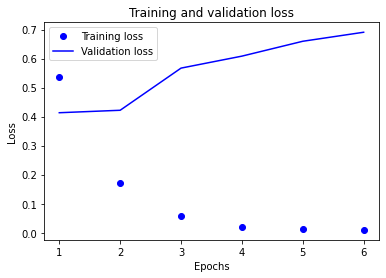

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

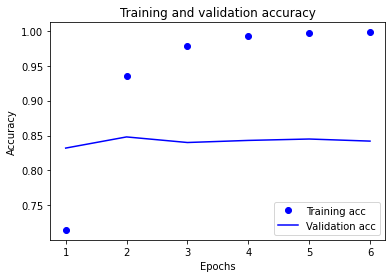

In [ ]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

fig2 = plt.gcf()

plt.draw()
fig2.savefig('fig2.png', dpi=100)

### 신경망 추론

In [ ]:
inference = load_model('checkpoint.h5')
y_pred = inference.predict(x_test)

In [ ]:
def submission_ypred():
    for i in range(len(y_pred)):
        if y_pred[i] < 0.5 :
            y_pred[i] = 0
        else:
            y_pred[i] = 1
    
submission_ypred()
submission['label']=y_pred
submission.to_csv('/content/drive/MyDrive/Colab Notebooks/dataset/BidirectionalLSTM.csv', index=False)